# Оценка стоимости квартир на основе объявлений с Циан

Добрый день/вечер!

Данный проект нацелен на предсказание стоимости квартир, находящихся в Москве и МО на основе их признакового описания. Данные были спаршены с сайта Циан с помощью библиотеки __cianparser__

In [ ]:
#!pip install cianparser

In [2]:
import pandas as pd
import numpy as np
import cianparser
from bs4 import BeautifulSoup
import requests
import re

import seaborn as sns
import matplotlib.pyplot as plt

## Парсинг данных

Для начала стоит спарсить квартиры, которые находятся в самой Москве

In [ ]:
moscow_parser = cianparser.CianParser(location="Москва")
first_part_data = moscow_parser.get_flats(
                               deal_type="sale", 
                               rooms='all', 
                               #with_saving_csv=True, 
                               additional_settings={"start_page":1, "end_page":54}
                              )

In [ ]:
df_moscow = pd.DataFrame(first_part_data)
df_moscow.head()

In [ ]:
# df_moscow.to_csv('/Users/nnn/Downloads/data.csv')

Однако как мы видим объектов мягко говоря маловато. Именно здесь пришла идея включить квартиры, которые расположены в Москвоской области. Посмотрим на список локаций, с которых парсер умеет парсить данные:

In [ ]:
locations = cianparser.list_locations()

Спарсим с Википедии список всех городов в МО

In [ ]:
#!pip install beautifulsoup4

In [ ]:
URL = 'https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9C%D0%BE%D1%81%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%B9_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B8'
page = requests.get(URL)
results = []
soup = BeautifulSoup(page.content, 'lxml')
letters = soup.find('div', class_='noresize')
for i in letters:
    try:
        if not i.find('span').text.isdigit() and i.find('span').text[0].isdigit():
            results.append(i.find('span').text)
    except:
        continue

results = list(set(results))
len(results)

In [ ]:
for i in range(len(results)):
    results[i] = re.sub(r'\d{1,2}', r'', results[i]).strip().replace('-', '')
results = list(set(results))

In [ ]:
x = len(results)
for i in results:
    if len(i.split()) > 1:
        el = ''.join(i.split())
        if el in results:
            results.remove(el)

Теперь выясним, какие подмосковные города есть в данной библиотеке, чтобы спарсить квартиры и из них

In [ ]:
interested_locations = []
for i in locations:
    if i[0] in results:
        interested_locations.append(i[0])
print(f'Есть {len(interested_locations)} город(а) из {len(results)}')

Подгружаем квартиры из городов, которые находятся в МО

In [ ]:
data_dict = {}
for i in interested_locations:
    parser = cianparser.CianParser(location=i)
    part_data = parser.get_flats(
                               deal_type="sale", 
                               rooms='all', 
                               additional_settings={"start_page":1, "end_page":5}
                              )
    part_df = pd.DataFrame(part_data)
    df_moscow = pd.concat([df_moscow, part_df], axis=0)

Сохраним датасет, чтобы не ждать каждый раз загрузки

In [ ]:
# df_moscow.to_csv('/Users/nnn/Downloads/data_MO.csv')

---

## Загрузка данных

In [3]:
df = pd.read_csv('data_MO.csv')
print(df.info())
df.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6537 entries, 0 to 6536
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           6537 non-null   int64  
 1   author               6415 non-null   object 
 2   author_type          6415 non-null   object 
 3   url                  6537 non-null   object 
 4   location             6537 non-null   object 
 5   deal_type            6537 non-null   object 
 6   accommodation_type   6537 non-null   object 
 7   floor                6537 non-null   int64  
 8   floors_count         6537 non-null   int64  
 9   rooms_count          6537 non-null   int64  
 10  total_meters         6537 non-null   float64
 11  price_per_month      6537 non-null   int64  
 12  commissions          6537 non-null   int64  
 13  price                6537 non-null   int64  
 14  district             3810 non-null   object 
 15  street               5564 non-null   o

,Unnamed: 0,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,price,district,street,house_number,underground,residential_complex
1724,32,NaN,NaN,https://dolgoprudny.cian.ru/sale/flat/299772838/,Долгопрудный,sale,flat,3,23,1,31.10,-1,0,7646544,NaN,NaN,NaN,Хлебниково,Бригантина ЖК
3666,90,Самолет,developer,https://balashikha.cian.ru/sale/flat/295382136/,Балашиха,sale,flat,11,22,2,57.79,-1,0,10277605,NaN,NaN,NaN,Некрасовка,Новоград Павлино


#### Вывод:

Данные подгружены успешно, в нашем распоряжении 6537 квартир и 17 описывающих признаков.

---

## Предобработка данных

__План__

проверить данные на:
- Дубликаты
- Отбор признаков
- Пропуски в данных
- Аномалии
- Подходящий тип данных

### Дубликаты

In [4]:
df.duplicated().sum()

0

#### Вывод:

явных признаков нет

### Отбор признаков

Давайте глянем на данные еще раз и подумаем какие из них можно просто убрать

In [5]:
df.sample(3)

,Unnamed: 0,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_month,commissions,price,district,street,house_number,underground,residential_complex
3389,93,Vysotsky Estate,real_estate_agent,https://khimki.cian.ru/sale/flat/301361940/,Химки,sale,flat,10,17,2,50.2,-1,0,9700000,NaN,Панфилова,17,Сходненская,NaN
989,989,Ксения Шахматова,realtor,https://www.cian.ru/sale/flat/300092420/,Москва,sale,flat,6,14,2,43.0,-1,0,14800000,Чертаново Северное,Кировоградская,6К1,Южная,NaN
2097,125,Борис Ларионов,realtor,https://zhukovsky.cian.ru/sale/flat/297851564/,Жуковский,sale,flat,2,4,-1,70.3,-1,0,2000000,NaN,Чкалова,15,Отдых,NaN


In [6]:
arr = []
for i in df.columns:
    arr.append(len(df[i].unique()))
    
data = {
    'columns': df.columns,
    'num_unique_elems': arr
}
svodka = pd.DataFrame(data=data).sort_values(by='num_unique_elems')
print('Сводка по уникальным значениям каждого признака')
svodka.head(7)

Сводка по уникальным значениям каждого признака


,columns,num_unique_elems
12,commissions,1
5,deal_type,1
6,accommodation_type,1
11,price_per_month,1
9,rooms_count,6
2,author_type,8
4,location,42


__Список ненужных признаков__
- `Unnamed: 0` -- тут все очевидно, это просто индекс, поэтому он и не нужен
- `url` -- к сожалению, ссылка ничем не поможет нам
- `deal_type` -- каждый объект имеет одинаковое значение этого признака, а значит он бесполезен
- `accommondation_type` -- каждый объект имеет одинаковое значение этого признака, а значит он бесполезен
- `price_per_month` -- каждый объект имеет одинаковое значение этого признака, а значит он бесполезен
- `commissions` -- каждый объект имеет одинаковое значение этого признака, а значит он бесполезен

In [7]:
df = df.drop(['Unnamed: 0', 'url', 'deal_type', 'accommodation_type', 'price_per_month', 'commissions'], axis=1)
df.sample(2)

,author,author_type,location,floor,floors_count,rooms_count,total_meters,price,district,street,house_number,underground,residential_complex
5161,ЕГСН Продажа,real_estate_agent,Мытищи,5,17,2,63.6,8850000,NaN,Стрелковая,21,Медведково,NaN
2427,Светлана Санданова,realtor,Краснознаменск,18,19,3,85.0,19000000,NaN,Победы,32,Апрелевка,Молодая семья


### Пропуски в данных

In [8]:
print('Процентное содержание пропусков')
round(df.isna().sum() / df.shape[0] * 100)

Процентное содержание пропусков


author                  2.0
author_type             2.0
location                0.0
floor                   0.0
floors_count            0.0
rooms_count             0.0
total_meters            0.0
price                   0.0
district               42.0
street                 15.0
house_number           11.0
underground            40.0
residential_complex    56.0
dtype: float64

Видим, что в некоторых случаях находится много пропусков. Теперь надо выбрать определенную стратегию под каждый признак.

---
__author__ и __author_type__

Тут ничего не сделаешь, поэтому придется заполнить пропуски метками `unknown`


In [9]:
print('Колличество объектов, в которых большое количество признаков -- пропуски')
df.loc[
       (df.district.isna()) & 
       (df.street.isna()) &
       (df.house_number.isna()) &
       (df.underground.isna()) &
       (df.residential_complex.isna())
      ].shape[0]

Колличество объектов, в которых большое количество признаков -- пропуски


201

Уберем такие объекты

In [10]:
df = df.loc[
       ~((df.district.isna()) & 
       (df.street.isna()) &
       (df.house_number.isna()) &
       (df.underground.isna()) &
       (df.residential_complex.isna()))
      ]

__house_number__ 

Данный признак невозможно восстановить, однако мне кажется, что такой признак н очень-то и важен, ведь кодировать данный признак будет сложно. Поэтому пропуски в данном признаке можно просто убрать 

In [11]:
df = df.loc[~(df.house_number.isna())]

__district__ и __street__, __underground__ и __residentional_complex__

Данные признаки сложно заполнить осмысленными значениями, но попытаться можно. Что касаемо __district__, то у объектов, у которых метро одинаковое, значит и район у них должен быть схож.

С __underground__ ситуация зеркальна с __district__. Правда придется принять, что пара __district__ -- __underground__ уникальны.

К сожалению, __residentional_complex__  может быть не единственным, как на улице, так и в районе.

С __street__ ситуация интереснее, на мой взгляд, данный признак не стоит того, чтобы его восстанавливать, так как его кодировка будет довольно трудоемкой.

__РЕАЛИЗАЦИИ ПОКА НЕТ__

### Аномалии

Очевидно, что начать стоит с непрерывных признаков

In [12]:
num_df = df.select_dtypes(['int64', 'float64'])
num_df.head()

,floor,floors_count,rooms_count,total_meters,price
1,4,9,2,87.90,158220000
3,3,19,-1,234.60,125000000
4,21,75,2,64.07,30790760
6,8,9,2,62.30,85974000
7,2,6,3,110.50,99000000


Нарисуем `boxplot`

             floor  floors_count  rooms_count  total_meters         price
count  5794.000000   5794.000000  5794.000000   5794.000000  5.794000e+03
mean      7.158785     13.063687     2.054021     66.942261  2.970030e+07
std       7.232519     10.560271     1.078971     51.287507  7.445587e+07
min      -1.000000     -1.000000    -1.000000     -1.000000  1.500000e+05
25%       3.000000      5.000000     1.000000     41.000000  5.400000e+06
50%       5.000000      9.000000     2.000000     53.350000  7.900000e+06
75%       9.000000     17.000000     3.000000     72.422500  1.450000e+07
max      70.000000     85.000000     5.000000    743.000000  1.200000e+09


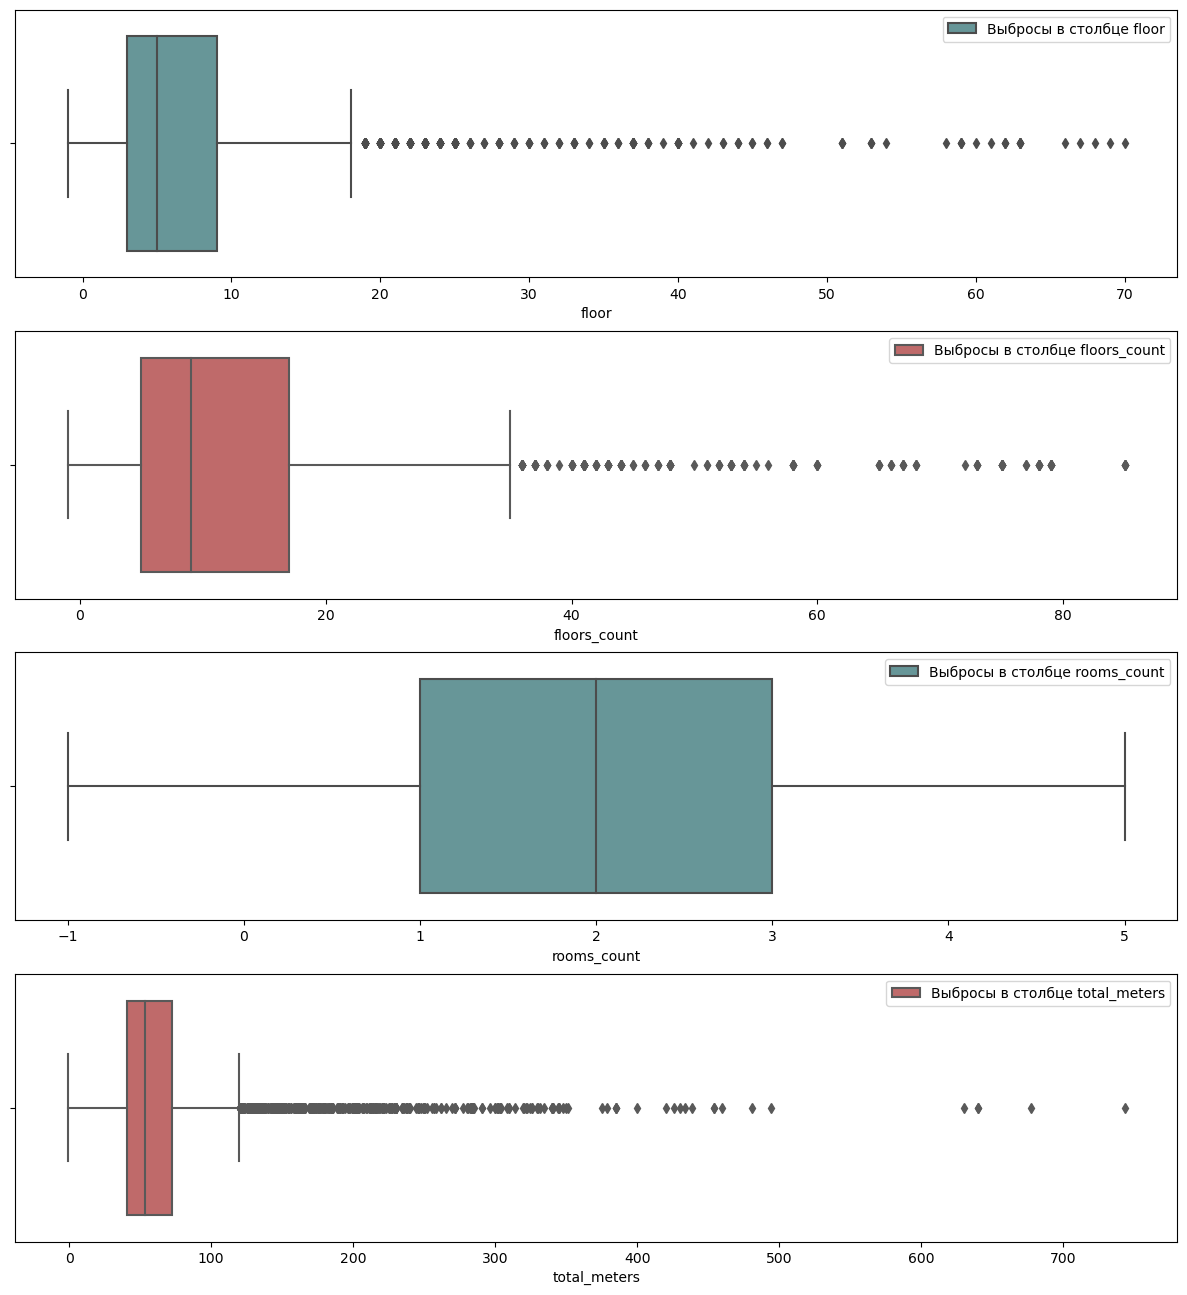

In [13]:
fig, axs = plt.subplots(4,1, figsize = (15, 16), sharey=True)

hist_1 = sns.boxplot(data=num_df, x="floor", color = 'cadetblue', ax = axs[0])
hist_1.legend(['Выбросы в столбце floor'])

hist_2 = sns.boxplot(data=num_df, x ="floors_count", color = "indianred",ax = axs[1])
hist_2.legend(['Выбросы в столбце floors_count'])

hist_3 = sns.boxplot(data=num_df, x ="rooms_count", color = "cadetblue",ax = axs[2])
hist_3.legend(['Выбросы в столбце rooms_count'])

hist_4 = sns.boxplot(data=num_df, x ="total_meters", color = "indianred",ax = axs[3])
hist_4.legend(['Выбросы в столбце total_meters'])

print(num_df.describe())
plt.show()

#### Вывод

Пройдемся по каждому столбцу:
- переменная __floor__ 

По графикам и таблице видно, что есть объекты со значениями -1 и 0. Очевидно, что это аномалия, такие признаки надо убрать

- переменная __floors_count__

Тут такая же ситуация, что и со __floor__

- переменная __rooms_count__

Тоже самое, что с предыдущими переменными

- переменная __total_meters__

Очевидно, что тут тоже странно видеть значения 0 и -1, однако ,на мой взгляд, нужно еще убрать квартиры с аномально маленьким значением данного признака. Возьмем за минимальное значение 15 кв. м. Также стоит убрать квартиры с аномльно большой площадью. За максимальное значение возьмем 300 кв. м.

In [14]:
bad_vals = [0, -1]
num_cols = num_df.columns

for i in num_cols:
    df = df.query(f'{i} not in @bad_vals')

In [15]:
df = df.loc[(15 <= df.total_meters) & (df.total_meters <= 300)]

#### Вывод 

Аномалии побеждены! 

### Подходящий тип данных

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5617 entries, 1 to 6536
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               5591 non-null   object 
 1   author_type          5591 non-null   object 
 2   location             5617 non-null   object 
 3   floor                5617 non-null   int64  
 4   floors_count         5617 non-null   int64  
 5   rooms_count          5617 non-null   int64  
 6   total_meters         5617 non-null   float64
 7   price                5617 non-null   int64  
 8   district             3490 non-null   object 
 9   street               5263 non-null   object 
 10  house_number         5617 non-null   object 
 11  underground          3358 non-null   object 
 12  residential_complex  2229 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 614.4+ KB


#### Вывод 

Все признаки имеют нормальный тип данных

---

## Визуализация данных

Начнем с непрерывных признаков, построим их гистограммы

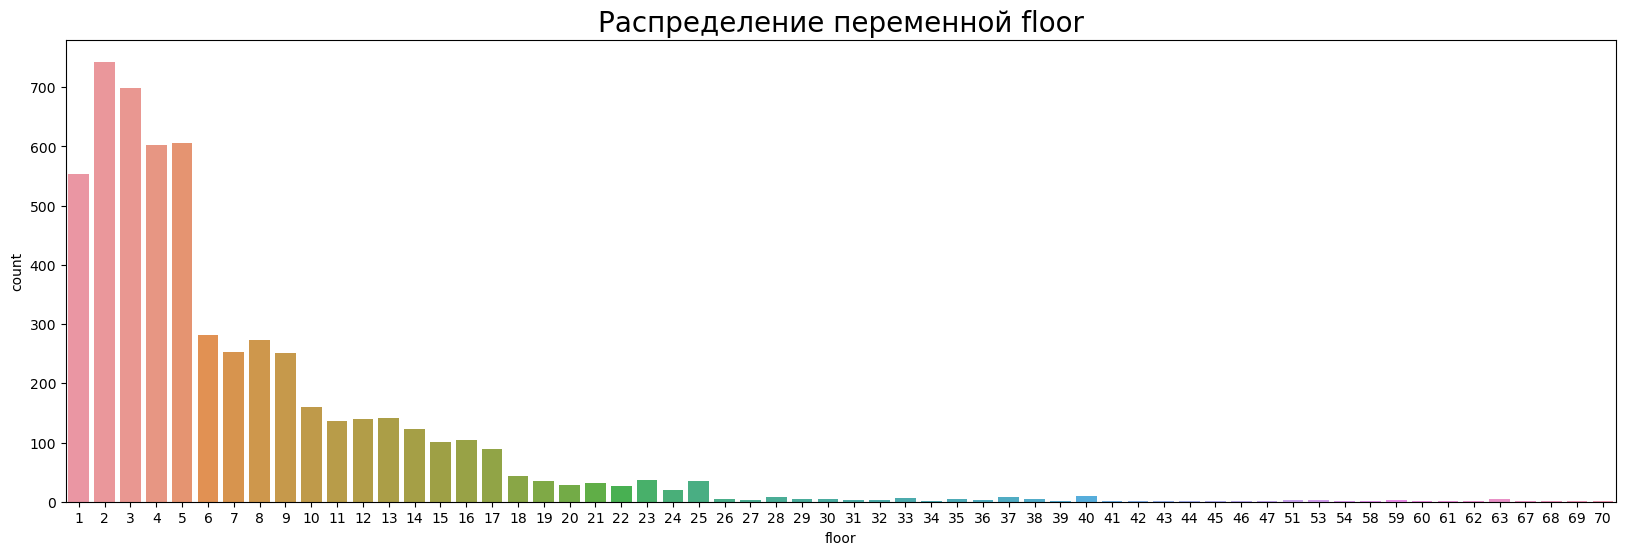

In [47]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='floor')
plt.title('Распределение переменной floor', fontsize=20);

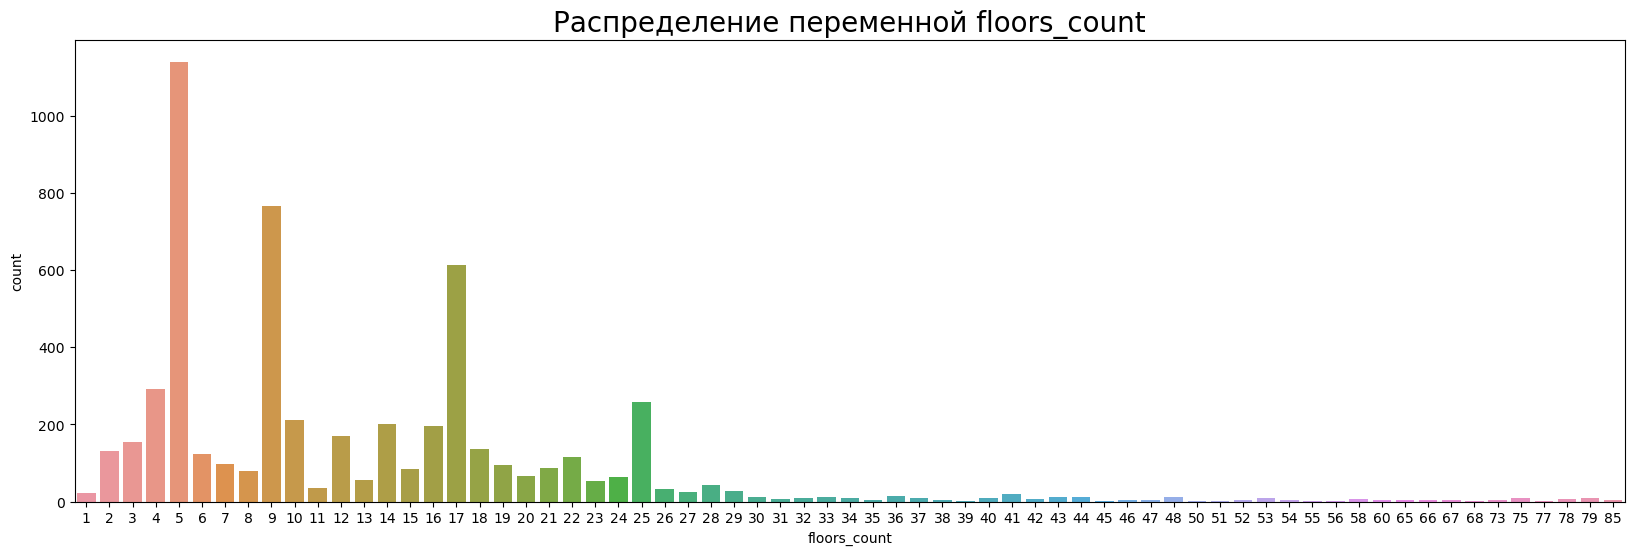

In [48]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='floors_count')
plt.title('Распределение переменной floors_count', fontsize=20);

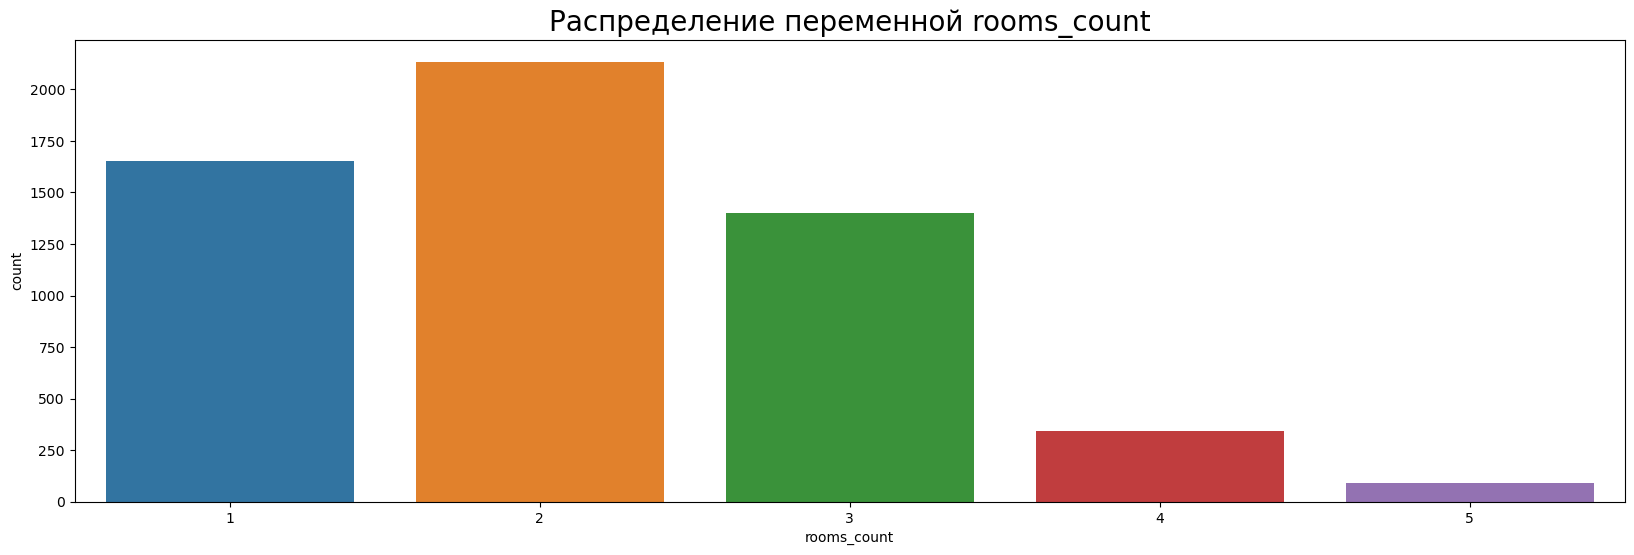

In [49]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='rooms_count')
plt.title('Распределение переменной rooms_count', fontsize=20);

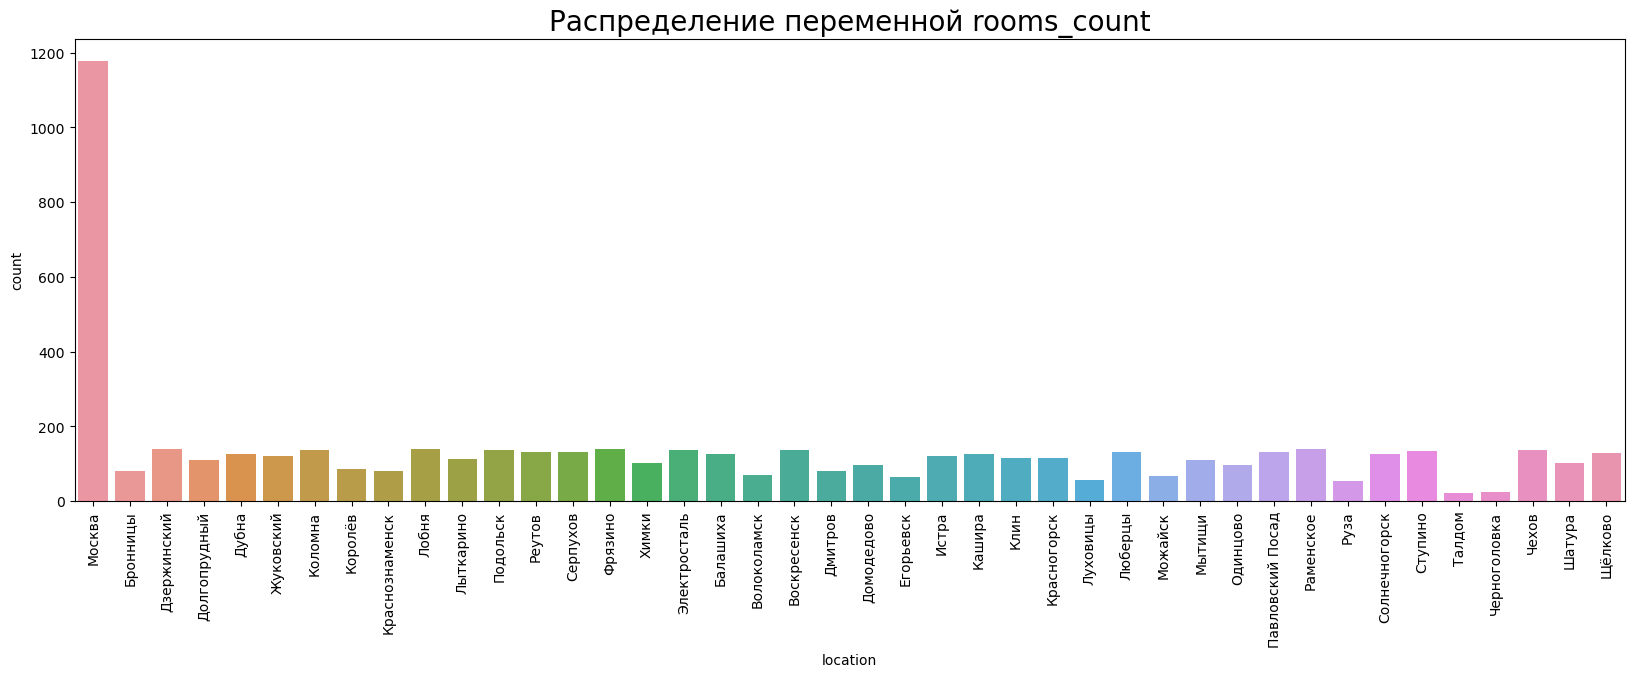

In [54]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df, x='location')
plt.xticks(rotation=90)
plt.title('Распределение переменной rooms_count', fontsize=20,);

---

## Гипотезы

### 1 Гиптеза

Н0: цена квартир в Москве и МО одинакова

Н1: цена квартир в Москве больше, чем в МО 